In [1]:
%pylab inline
import pandas as pd
import sys
import gc

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0,"../python/rrvf2017/")

In [3]:
from rrvf_data import read_data,show_data,show_data2,show_features, normalize, DataGen

In [4]:
columns,data=read_data()
len(columns),data.shape

(1, 829, 517) (54, 829, 517)


(62, (829, 517, 62))

In [5]:
gc.collect()

15

In [6]:
#show_data(data,columns, 1,480, None)

In [7]:
#show_data2(data,columns)

# cv

In [8]:
n_reg_lookback=42
n_lookforward=1

In [9]:
def get_index(cols):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [10]:
rawy=data[:,:,get_index(['visitors'])[0]].copy()
rawy.shape

(829, 517)

In [11]:
ondate_cols=[ u'visitor_lag91', u'visitor_lag182',
       u'visitor_lag364',u'TMAX', u'TMIN', u'TAVG', u'PRCP', u'holiday',
            'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2',
       'weekday1', 'weekday0']
#ondate_cols=[ u'PRCP']
#ondate_cols=columns
ondate_train_test=data[:,:,get_index(ondate_cols)].copy()
ondate_train_test=normalize(ondate_train_test)
ondate_train_test.shape

(15,) 0.0676983 123.876


(829, 517, 15)

In [12]:
lag_cols=columns

lag_cols=array([u'visitors', u'geo1_visitors_mean', u'geo2_visitors_mean',
       u'station_visitors_mean', u'genre_name_visitors_mean',
       u'day_of_week_visitors_mean', u'visitor_lag7', u'visitor_lag14',
       u'visitor_lag28', u'visitor_lag91', u'visitor_lag182',
       u'visitor_lag364', u'visitor_ma2', u'visitor_ma4', u'visitor_ma7',
       u'visitor_ma14', u'visitor_ma28', u'visitor_ma56', u'visitor_ma112',
       u'visitor_ma224', u'visitor_sma1', u'visitor_sma2', u'visitor_sma3',
       u'visitor_sma4', u'visitor_sma8', u'visitor_sma16',
       u'visitor_sma32'])
#lag_cols=['holiday']
lag_train_test=data[:,:,get_index(lag_cols)].copy()
lag_train_test=normalize(lag_train_test)
lag_train_test.shape

(27,) 2.78591754939 3.02795093092


(829, 517, 27)

In [13]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [14]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [15]:
print K.floatx()

float32


In [16]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [17]:
train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1,478-n_lookforward*7, batchsize=128,valid_split=0.1,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
valid_gen=None
test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-n_lookforward*7,478, batchsize=128,lookback1=n_reg_lookback, lookforward=n_lookforward)

rand split across time
train has 319288 records out of 354812 records
valid has 35524 records out of 354812 records
train has 5803 records out of 5803 records
no valid set


In [18]:
print train_gen.train_steps_per_epoch
print 0 if valid_gen is None else valid_gen.train_steps_per_epoch

2494
0


In [19]:
#show_features(train_gen,ondate_cols,lag_cols,rawy,0,467,filter_fn=lambda u: 'y_0' in u)

In [20]:
lag_input_dim=lag_train_test.shape[-1]
ondate_input_dim=ondate_train_test.shape[-1]
lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)

(27, 15, (1, 15))

In [21]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[3],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 3})

In [22]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [23]:
backend.clear_session()
set_session(tf.Session(config=config))   
a=rrvf.KerasModel("test", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                  ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim,
                  max_epoch=200, use_output_exp=True,
                  params=parameter)
a._make_model()
a.params

(?, 42, 54)


{'activation': 'relu',
 'batch_normalization': False,
 'l2': 1e-06,
 'loss': 'mean_squared_error',
 'metric': 'mean_squared_error',
 'optimizer': 'adam',
 'patience': 3}

In [24]:
#a.model.summary()
a.model.count_params()

459009

In [25]:
a.fit(train_gen,valid_gen)

Epoch 1/200
2494/2494 [==============================] - 47s 19ms/step - loss: 0.3140 - total_loss: 0.3140 - reg_loss: 0.3140 - val_loss: 0.3491 - val_total_loss: 0.3491 - val_reg_loss: 0.3491
Epoch 2/200
2494/2494 [==============================] - 46s 18ms/step - loss: 0.2838 - total_loss: 0.2838 - reg_loss: 0.2838 - val_loss: 0.3051 - val_total_loss: 0.3051 - val_reg_loss: 0.3051
Epoch 3/200
2494/2494 [==============================] - 46s 18ms/step - loss: 0.2759 - total_loss: 0.2759 - reg_loss: 0.2759 - val_loss: 0.2873 - val_total_loss: 0.2873 - val_reg_loss: 0.2873
Epoch 4/200
2494/2494 [==============================] - 46s 18ms/step - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707 - val_loss: 0.2768 - val_total_loss: 0.2768 - val_reg_loss: 0.2768
Epoch 5/200
2494/2494 [==============================] - 46s 18ms/step - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649 - val_loss: 0.2781 - val_total_loss: 0.2781 - val_reg_loss: 0.2781
Epoch 6/200
2494/2494 [============

<rrvf_model.KerasModel instance at 0x7f408a851440>

In [26]:
a.traingen=train_gen

In [27]:
a.eval_valid()

best_epochs [7, 9, 4, 6, 5]
0.268163378499 0.268163378499
(1, 0.26816337849930572)


In [28]:
yy_pred=a.predict(300)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [7, 9, 4, 6, 5]
(829, 1) 2.65149593522 (829,)
0.23253399984 0.23253399984
(1, 0.23253399984046047)


In [29]:
traindata=train_gen.get_train()

In [30]:
def predict_train(self):
    X, y, mask,w = self.traingen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X

In [31]:
def predict_test(self):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X

In [32]:
gc.collect()

735

In [33]:
result=predict_train(a)

best_epochs [7, 9, 4, 6, 5]
(319288, 1) 2.68885791595 (319288, 2)


In [34]:
result[4].keys()

['masky', 'ondatex', 'lagx']

In [35]:
result[4]['lagx'].shape

(319288, 42, 27)

In [36]:
df=pd.DataFrame({'y':result[2][:,0]})

In [37]:
df['pred']=result[0][:,0]
df['dayidx']=result[1][:,1]

In [38]:
df=df.loc[df['y']>0]

In [39]:
df['error']=df['y']-df['pred']
df['error2']=df['error']**2


In [42]:
import rrvf_data

In [43]:
df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)

In [45]:
import seaborn as sns; sns.set(color_codes=True)

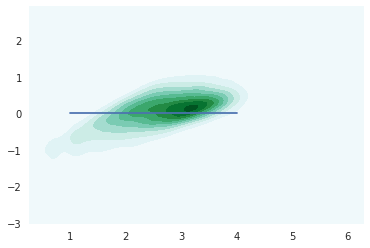

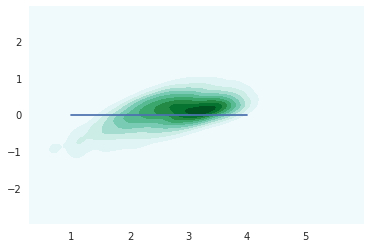

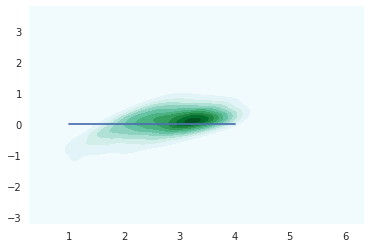

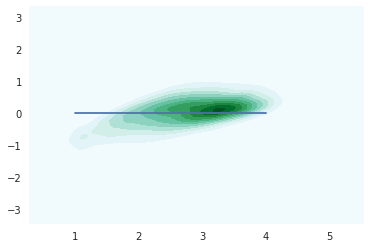

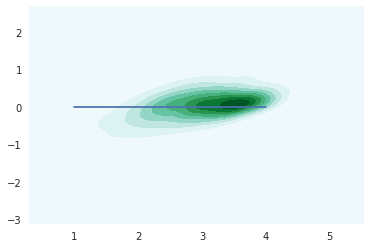

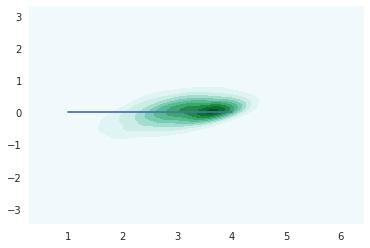

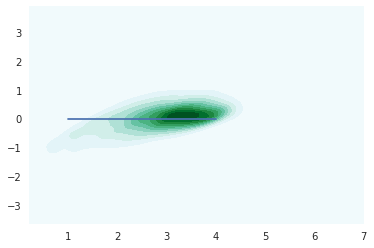

In [46]:
for i in range(1,8):
    plt.plot(np.arange(1,5),np.arange(1,5)*0)
    sns.kdeplot(df['y'][df['day']==i].values,df['error'][df['day']==i].values, shade=True)
    plt.show()

1


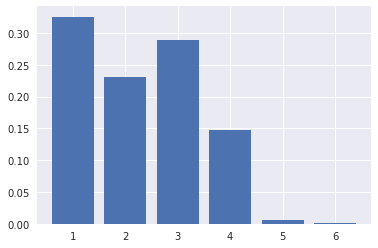

2


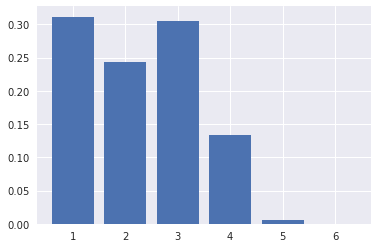

3


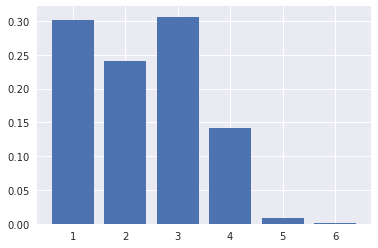

4


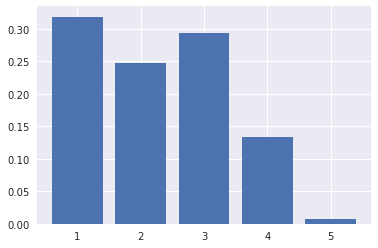

5


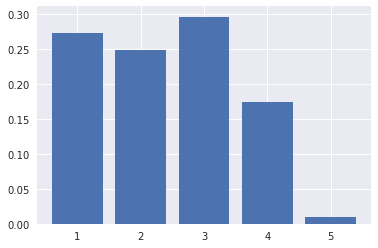

6


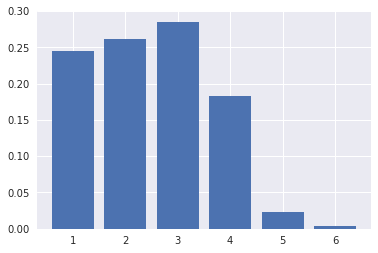

7


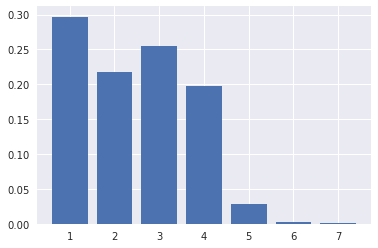

In [47]:
df['tmp']=np.round(df['y'])
for i in range(1,8):
    print i
    s=df[['tmp','error2']][df['day']==i].groupby('tmp').sum().iloc[:,0]
    plt.bar(s.index,s.values/s.sum())
    plt.show()

In [48]:
gc.collect()

72049

In [49]:
df2=df.groupby("dayidx").mean() 

In [50]:
df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())

In [51]:
df2[['day','error2']].groupby('day').median()

error2
day          
1    0.271366
2    0.246102
3    0.236125
4    0.247199
5    0.195641
6    0.204345
7    0.276776

In [52]:
rrvf_data.idx_to_date([477])

array(['2017-04-22'],
      dtype='|S10')

1


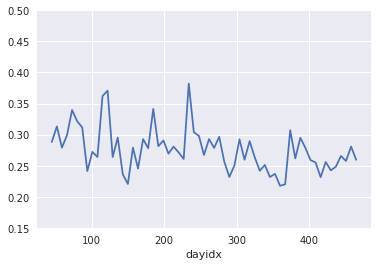

2


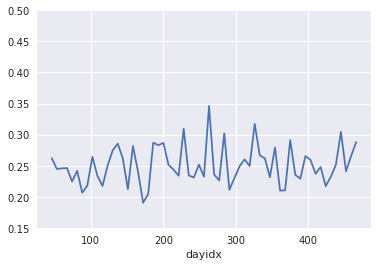

3


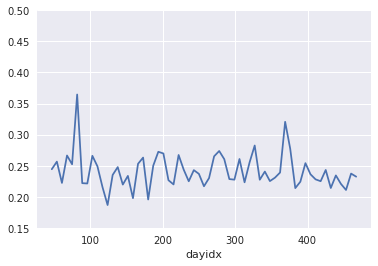

4


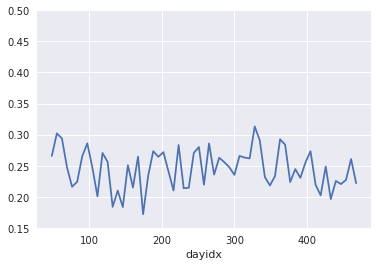

5


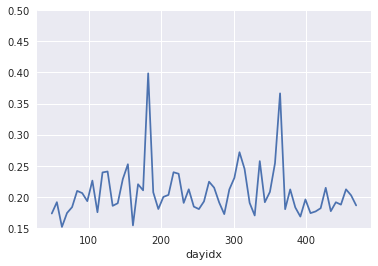

6


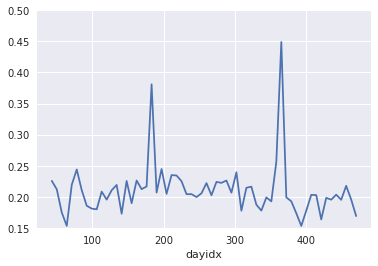

7


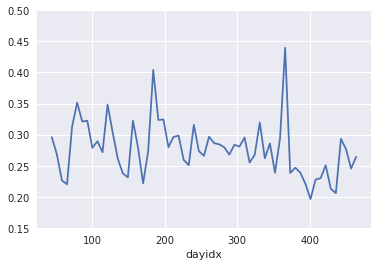

In [54]:
for i in range(1,8):
    print i
    df2[df2['day']==i]['error2'].plot();
    plt.ylim([0.15,0.5])
    plt.show()

In [55]:
df2.sort_values('error2').tail(20)

y      pred     error    error2  day       tmp        date
dayidx                                                                   
80      2.931774  2.927278  0.004496  0.321578    1  2.923497  2016-03-21
93      2.891628  2.971780 -0.080152  0.322321    7  2.895833  2016-04-03
156     2.839855  2.879785 -0.039930  0.322411    7  2.850746  2016-06-05
191     2.877363  2.838370  0.038993  0.323583    7  2.885277  2016-07-10
198     3.012873  2.880436  0.132437  0.324338    7  3.001822  2016-07-17
73      2.594769  2.600706 -0.005937  0.339650    1  2.576744  2016-03-14
185     2.569296  2.589361 -0.020065  0.341301    1  2.559140  2016-07-04
263     2.372741  2.472626 -0.099885  0.346116    2  2.380952  2016-09-20
121     2.999386  2.938880  0.060506  0.348303    7  3.004926  2016-05-01
79      3.107793  3.075942  0.031851  0.351367    7  3.129630  2016-03-20
115     2.644006  2.638925  0.005081  0.362082    1  2.625571  2016-04-25
82      2.763394  2.855044 -0.091650  0.364594    3  2.770751  2016-03-23
364     3.026619  3.053267 -0.026647  0.366428    5  3.025391  2016-12-30
122     2.929077  2.665169  0.263908  0.370748    1  2.945455  2016-05-02
183     3.044233  3.056459 -0.012225  0.380982    6  3.039275  2016-07-02
234     2.343457  2.440478 -0.097021  0.382087    1  2.358095  2016-08-22
182     2.982055  2.943631  0.038424  0.398585    5  2.994118  2016-07-01
184     2.864006  2.805907  0.058099  0.404013    7  2.849315  2016-07-03
366     2.711672  2.768313 -0.056640  0.439821    7  2.713178  2017-01-01
365     2.664184  2.756243 -0.092059  0.449062    6  2.664286  2016-12-31

In [56]:
result=predict_test(a)

best_epochs [7, 9, 4, 6, 5]
(5803, 1) 2.71721624307 (5803, 2)


In [57]:
df=pd.DataFrame({'y':result[2][:,0]})

In [58]:
df['pred']=result[0][:,0]
df['dayidx']=result[1][:,1]

In [59]:
df=df.loc[df['y']>0]

In [60]:
df['error']=df['y']-df['pred']
df['error2']=df['error']**2


In [61]:
df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)

In [62]:
df2=df.groupby("dayidx").mean() 

In [63]:
df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())

In [64]:
df2

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.928000  0.001110  0.261835    7  2017-04-16
472     2.507290  2.561936 -0.054645  0.248469    1  2017-04-17
473     2.661330  2.629862  0.031467  0.272522    2  2017-04-18
474     2.754815  2.694743  0.060072  0.235888    3  2017-04-19
475     2.713762  2.706944  0.006817  0.264599    4  2017-04-20
476     2.999000  2.939538  0.059462  0.171314    5  2017-04-21
477     3.075529  3.124471 -0.048941  0.204625    6  2017-04-22

# time split

In [32]:
train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1,478-n_lookforward*4, 
                  batchsize=128,valid_split=0.0,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward,valid_type=None)
valid_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-n_lookforward*4,478-n_lookforward*2, 
                  batchsize=128,valid_split=0.0,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward,valid_type=None)
test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-n_lookforward,478, batchsize=128,lookback1=n_reg_lookback, lookforward=n_lookforward)

train has 357299 records out of 357299 records
no valid set
train has 1658 records out of 1658 records
no valid set
train has 829 records out of 829 records
no valid set


In [33]:
print train_gen.train_steps_per_epoch
print 0 if valid_gen is None else valid_gen.train_steps_per_epoch

2791
12


In [34]:
#show_features(train_gen,ondate_cols,lag_cols,rawy,0,467,filter_fn=lambda u: 'y_0' in u)

In [35]:
lag_input_dim=lag_train_test.shape[-1]
ondate_input_dim=ondate_train_test.shape[-1]
lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)

(27, 8, (1, 8))

In [36]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[3],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 3})

In [37]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [38]:
backend.clear_session()
set_session(tf.Session(config=config))   
a=rrvf.KerasModel("test", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                  ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim,
                  max_epoch=200,
                  params=parameter)
a._make_model()
a.params

(?, 42, 54)


{'activation': 'relu',
 'batch_normalization': False,
 'l2': 1e-06,
 'loss': 'mean_squared_error',
 'metric': 'mean_squared_error',
 'optimizer': 'adam',
 'patience': 3}

In [39]:
#a.model.summary()
print gc.collect()
a.model.count_params()

454


455425

In [40]:
a.fit(train_gen,valid_gen)

Epoch 1/200
2791/2791 [==============================] - 57s 20ms/step - loss: 0.3199 - total_loss: 0.3199 - reg_loss: 2.5995 - val_loss: 0.2717 - val_total_loss: 0.2717 - val_reg_loss: 0.9499
Epoch 2/200
2791/2791 [==============================] - 56s 20ms/step - loss: 0.2837 - total_loss: 0.2837 - reg_loss: 2.5131 - val_loss: 0.2499 - val_total_loss: 0.2499 - val_reg_loss: 0.8878
Epoch 3/200
2791/2791 [==============================] - 56s 20ms/step - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 2.4670 - val_loss: 0.2563 - val_total_loss: 0.2563 - val_reg_loss: 0.8219
Epoch 4/200
2791/2791 [==============================] - 57s 20ms/step - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 2.4382 - val_loss: 0.2747 - val_total_loss: 0.2747 - val_reg_loss: 0.8155
Epoch 5/200
2791/2791 [==============================] - 56s 20ms/step - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 2.3925 - val_loss: 0.2606 - val_total_loss: 0.2606 - val_reg_loss: 0.8171


<rrvf_model.KerasModel instance at 0x7f7e885d5d88>

In [41]:
#a.traingen=train_gen

In [42]:
a.eval_valid()

best_epochs [2, 3, 5, 1, 4]
0.258842468217 0.258842468217
(1, 0.25884246821678769)


In [43]:
yy_pred=a.predict(400)

best_epochs [1, 2, 3, 4, 5]
(829, 1) 3.02983174963 (829,)


In [44]:
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

0.190820011306 0.190820011306
(1, 0.19082001130563031)


In [49]:
n_lookforward

1

In [50]:
yy_pred=a.predict(478-n_lookforward-1)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [1, 2, 3, 4, 5]
(829, 1) 2.87643025494 (829,)
0.182698888629 0.182698888629
(1, 0.18269888862869477)


In [51]:
yy_pred=a.predict(478-n_lookforward-2)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [1, 2, 3, 4, 5]
(829, 1) 2.62079328142 (829,)
0.270138534272 0.270138534272
(1, 0.27013853427158546)


In [52]:
yy_pred=a.predict(478-n_lookforward-3)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [1, 2, 3, 4, 5]
(829, 1) 2.60231247107 (829,)
0.243763329538 0.243763329538
(1, 0.24376332953775123)


In [53]:
yy_pred=a.predict(478-n_lookforward-4)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [1, 2, 3, 4, 5]
(829, 1) 2.52984273246 (829,)
0.278246599289 0.278246599289
(1, 0.27824659928872975)


In [45]:
yy_pred=a.predict(478-n_lookforward)

best_epochs [1, 2, 3, 4, 5]
(829, 1) 3.06015446194 (829,)


In [46]:
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

0.209365883356 0.209365883356
(1, 0.20936588335586601)
